# Acceptance of Personal Loan

Excerpt From: Galit Shmueli. “Data Mining for Business Analytics.”


Universal Bank is a relatively young bank that is growing rapidly in terms of overall customer acquisition. The majority of these customers are liability customers with varying sizes of relationship with the bank. The customer base of asset customers is quite small, and the bank is interested in growing this base rapidly to bring in more loan business. In particular, it wants to explore ways of converting its liability (deposit) customers to personal loan customers.

A campaign the bank ran for liability customers showed a healthy conversion rate of over 9% successes. This has encouraged the retail marketing department to devise smarter campaigns with better target marketing. The goal of our analysis is to model the previous campaign’s customer behavior to analyze what combination of factors make a customer more likely to accept a personal loan. This will serve as the basis for the design of a new campaign.

The bank’s dataset includes data on 5000 customers. The data include customer demographic information (age, income, etc.), customer response to the last personal loan campaign (Personal Loan), and the customer’s relationship with the bank (mortgage, securities account, etc.).

In [1]:
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
import pandas as pd
from dmba import classificationSummary, regressionSummary

In [2]:
bank_df = pd.read_csv(r'data/UniversalBank.csv')
bank_df.drop(columns=['ID', 'ZIP Code'], inplace=True)
bank_df.head()

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,25,1,49,4,1.6,1,0,0,1,0,0,0
1,45,19,34,3,1.5,1,0,0,1,0,0,0
2,39,15,11,1,1.0,1,0,0,0,0,0,0
3,35,9,100,1,2.7,2,0,0,0,0,0,0
4,35,8,45,4,1.0,2,0,0,0,0,0,1


In [3]:
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 5000 non-null   int64  
 1   Experience          5000 non-null   int64  
 2   Income              5000 non-null   int64  
 3   Family              5000 non-null   int64  
 4   CCAvg               5000 non-null   float64
 5   Education           5000 non-null   int64  
 6   Mortgage            5000 non-null   int64  
 7   Personal Loan       5000 non-null   int64  
 8   Securities Account  5000 non-null   int64  
 9   CD Account          5000 non-null   int64  
 10  Online              5000 non-null   int64  
 11  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 468.9 KB


#### Create the independent and dependent features. Split the dataset into train and test:

In [4]:
X = bank_df.drop(columns=['Personal Loan'])
y = bank_df['Personal Loan']
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.4, random_state=1)
train_X.shape,test_X.shape,train_y.shape,test_y.shape

((3000, 11), (2000, 11), (3000,), (2000,))

### (1) Train a Random Forest Classifier

In [5]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
rf = RandomForestClassifier(n_estimators=500, random_state=1)
rf.fit(train_X, train_y)

# variable (feature) importance plot
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

df = pd.DataFrame({'feature': train_X.columns, 'importance': importances, 'std': std})
df = df.sort_values('importance')
print(df)

               feature  importance       std
7   Securities Account    0.003964  0.004998
9               Online    0.006394  0.005350
10          CreditCard    0.007678  0.007053
6             Mortgage    0.034243  0.023469
1           Experience    0.035539  0.016061
0                  Age    0.036258  0.015858
8           CD Account    0.057917  0.043185
3               Family    0.111375  0.053146
4                CCAvg    0.172105  0.103011
5            Education    0.200772  0.101002
2               Income    0.333756  0.129227


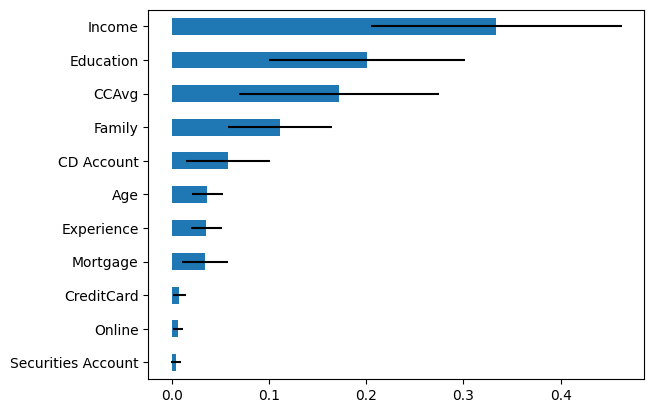

In [6]:
import matplotlib.pyplot as plt

ax = df.plot(kind='barh', xerr='std', x='feature', legend=False)
ax.set_ylabel('')
plt.show()

In [7]:
# confusion matrix for validation set
classificationSummary(test_y, rf.predict(test_X))

Confusion Matrix (Accuracy 0.9820)

       Prediction
Actual    0    1
     0 1803    4
     1   32  161


The validation accuracy of the random forest in this example (0.982) is similar to the single fine-tuned tree, and slightly higher than the single small tree that we fit earlier (0.977).

The graph shows the variable importance plot generated from the random forest model for the personal loan example. We see that Income and Education have the highest scores, with CCAvg being third. Importance scores for the other predictors are considerably lower.

### (2) Train a Boosted Tree

In [8]:
from sklearn.ensemble import GradientBoostingClassifier
boost = GradientBoostingClassifier()
boost.fit(train_X, train_y)
classificationSummary(test_y, boost.predict(test_X))

Confusion Matrix (Accuracy 0.9835)

       Prediction
Actual    0    1
     0 1799    8
     1   25  168


We can see that compared to the performance of the single small tree, the boosted tree has better performance on the test data in terms of overall accuracy (0.9835) and especially in terms of correct classification of 1’s—the rare class of special interest.

Where does boosting’s special talent for finding 1’s come from? When one class is dominant (0’s constitute over 90% of the data here), basic classifiers are tempted to classify cases as belonging to the dominant class, and the 1’s in this case constitute most of the misclassifications with the single tree. The boosting algorithm concentrates on the misclassifications (which are mostly 1’s), so it is naturally going to do well in reducing the misclassification of 1’s (from 43 in the single small tree to 25 in the boosted tree, in the test set).